## Fine-tuning (& Reinforcement Learning)

In this section we will work exclusively with local models. We will first see how a small local model perform on the task of coverage check out of the box. We will then see how we can improve that model further with Supervised Fine Tuning. Finally we will see if reinforcement learning can help by adding reasoning capabilities to our model specifically tailored to reason about claims.

For illustration purposes but also to fit in limited memory constraint environment of this workshop, we will use [Qwen2.5 3B](https://qwenlm.github.io/blog/qwen2.5/) which really shows impressive performances for it's size. (careful the 3B version is non-commercialy licensed)

To actually perform the finetuning we will leverage the library [unsloth](https://docs.unsloth.ai/). Unsloth makes it possible to finetune LLMs extremly fast and with very limited resources by using a few tricks:
- it uses [QLoRA](https://arxiv.org/abs/2305.14314) by default and enabling to load model in 4bit (we will talk about it a bit more)
- custom [OpenAI's triton](https://openai.com/index/triton/) CUDA kernels to speed up finetuning
- it recently also optimized inference further by leveraging [vllm](https://github.com/vllm-project/vllm) on optimized inference server.

Finally, still using unsloth we will be able to use Grouped Policy Optimization (GRPO) the same technique DeepSeek R1 is using to transform our model into a reasoning model tailored to reason about claims.

### Qwen 2.5 baseline

Before even starting to finetune our performing reinforcement learning, we need to establish our baseline with Qwen 2.5 3B.

#### load and prepare the dataset

We will load the same dataset as used in the previous part of this workshop. That is 400 synthtetic claims about a car insurance policy of AXA UK.

In [9]:
# we use pydantic models to help you navigate / type the dataset
from models import ClaimsDataset

with open("data/claims_dataset_v2_manual.json", "r") as f:
    dataset = ClaimsDataset.model_validate_json(f.read())

print(f"loaded dataset with {len(dataset.root)} claims.")

loaded dataset with 400 claims.


In [10]:
# you can use python 'help' to see the content of the pydantic model
from models import Claim

help(Claim)

Help on class Claim in module models:

class Claim(pydantic.main.BaseModel)
 |  Claim(*, description: str, explanation: str, coverage: bool, sources: list[models.Source], source_rule: models.SourceRuleContainer, limit_unit: str | None = None, limit_amount: float | None = None, limit_targets: list[str]) -> None
 |
 |  Represents an individual insurance claim with all its details and
 |  associated rules.
 |
 |  Attributes:
 |      description (str): Detailed description of the claim scenario
 |      explanation (str): Additional explanation or notes about the claim
 |      coverage (bool): Whether the claim is covered under the policy
 |      sources (list[Source]): Relevant policy document excerpts supporting
 |          the claim
 |      source_rule (SourceRuleContainer): Collection of rules applicable to
 |          the claim
 |      limit_unit (Optional[str]): Currency unit for the claim limit (e.g.,
 |          "GBP")
 |      limit_amount (Optional[float]): Maximum amount covered f

In [12]:
claims = dataset.root
covered_claims = [claim for claim in claims if claim.coverage]
not_covered_claims = [claim for claim in claims if not claim.coverage]

print(f"there are {len(covered_claims)} covered claims and {len(not_covered_claims)} not covered claims.")

there are 126 covered claims and 274 not covered claims.


We loaded the 400 claims it's fairly unbalanced with 68.5% of claims not covered and 31.5% covered. So when splitting into train / test set we will need to check the proportion in the split to make sure we are not too far off.

#### split train / test dataset

To make sure our results are comparable we first split the dataset into a training and testing set. We will establish our baseline only on the test set. The train set will be use to finetune the model and then the finetuned model will be evaluated on the test set again. 

Note here that in a real world setting I would probably set a Stratified K fold CV to ensure the proportion of covered / not covered across several splits. For the purpose of this workshop we keep things simple.

In [25]:
import random

# shuffle randomly the claims with reproducibility
random.seed(42)
random.shuffle(claims)

# keep 80% as training set, 20% as testing set.
split_ratio = 0.8
train_size = int(len(claims) * split_ratio)

train_claims = claims[:train_size]
test_claims = claims[train_size:]

print(f"split {len(claims)} claims into {len(train_claims)} training claims and {len(test_claims)}")

split 400 claims into 320 training claims and 80


In [31]:

covered_train_claims = [claim for claim in train_claims if claim.coverage]
not_covered_train_claims = [claim for claim in train_claims if not claim.coverage]

print(f"{len(covered_train_claims)*100/len(train_claims)}% covered, {len(not_covered_train_claims)*100/len(train_claims)}% not covered")

29.0625% covered, 70.9375% not covered


In [32]:
covered_test_claims = [claim for claim in test_claims if claim.coverage]
not_covered_test_claims = [claim for claim in test_claims if not claim.coverage]

print(f"{len(covered_test_claims)*100/len(test_claims)}% covered, {len(not_covered_test_claims)*100/len(test_claims)}% not covered")

41.25% covered, 58.75% not covered


We see a slightly difference in the proportion of covered not covered between our training and testing set that could potentially impact our end results. To do it better we could make a stratified split for example using sklearn.

### Split Train / Test

In [ ]:
import random
from copy import deepcopy

# Seed for reproducibility
random.seed(42)

def split_train_test(
    dataset: ClaimsDataset, split_ratio: float = 0.8
) -> tuple[list[Claim], list[Claim]]:
    """
    Split the dataset into train and test sets.

    Args:
        dataset: The dataset to split.
        split_ratio: The ratio of the dataset to use for the train set.

    Returns:
        A tuple of two lists of claims: the train set and the test set.
    """
    # shuffle the dataset
    # we could use a stratified split to make sure we have
    # the same proportion of covered and not covered claims in the train and test set
    dataset_copy = deepcopy(dataset)

    # shuffle the dataset to take a random split
    random.shuffle(dataset_copy.root)

    train_size = int(len(dataset_copy.root) * split_ratio)

    return dataset_copy.root[:train_size], dataset_copy.root[train_size:]


train_dataset, test_dataset = split_train_test(dataset)
len(train_dataset), len(test_dataset)

(320, 80)

In [6]:
(
    len([claim for claim in test_dataset if claim.coverage]),
    len([claim for claim in test_dataset if claim.coverage]) / len(test_dataset),
)

(28, 0.35)

In [7]:
(
    len([claim for claim in test_dataset if not claim.coverage]),
    len([claim for claim in test_dataset if not claim.coverage]) / len(test_dataset),
)

(52, 0.65)

### Establish baseline performance Qwen2.5(3B)

In [9]:
import torch

print(f"CUDA version: {torch.version.cuda}")

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Get the current device info if CUDA is available
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")

CUDA version: 12.4
CUDA available: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 2070


In [10]:
from unsloth import FastLanguageModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 02-10 14:13:21 __init__.py:190] Automatically detected platform cuda.


In [11]:
from unsloth import is_bfloat16_supported
import torch

max_seq_length = 1024  # Can increase for longer reasoning traces
lora_rank = 64  # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B-Instruct",
    max_seq_length=max_seq_length,
    load_in_4bit=True,  # False for LoRA 16bit
    fast_inference=True,  # Enable vLLM fast inference
    max_lora_rank=lora_rank,
    gpu_memory_utilization=0.5,  # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r=lora_rank,  # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],  # Remove QKVO if out of memory
    lora_alpha=lora_rank,
    use_gradient_checkpointing="unsloth",  # Enable long context finetuning
    random_state=3407,
)

==((====))==  Unsloth 2025.2.5: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA GeForce RTX 2070. Max memory: 7.607 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit with actual GPU utilization = 43.61%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 7.61 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 0.9 GB. Also swap space = 5 GB.
WARNING 02-10 14:13:29 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-10 14:13:36 config.py:542] This model supports multiple tasks: {'embed', 'classify', 'score', 'reward', 'ge

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-10 14:13:40 model_runner.py:1115] Loading model weights took 2.2265 GB
INFO 02-10 14:13:40 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 02-10 14:13:42 worker.py:267] Memory profiling takes 1.22 seconds
INFO 02-10 14:13:42 worker.py:267] the current vLLM instance can use total_gpu_memory (7.61GiB) x gpu_memory_utilization (0.44) = 3.32GiB
INFO 02-10 14:13:42 worker.py:267] model weights take 2.23GiB; non_torch_memory takes 0.12GiB; PyTorch activation peak memory takes 0.70GiB; the rest of the memory reserved for KV Cache is 0.27GiB.
INFO 02-10 14:13:42 executor_base.py:110] # CUDA blocks: 490, # CPU blocks: 9102
INFO 02-10 14:13:42 executor_base.py:115] Maximum concurrency for 1024 tokens per request: 7.66x
INFO 02-10 14:13:48 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs

Capturing CUDA graph shapes: 100%|██████████| 19/19 [00:12<00:00,  1.48it/s]

INFO 02-10 14:14:01 model_runner.py:1562] Graph capturing finished in 13 secs, took 0.43 GiB
INFO 02-10 14:14:01 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 20.48 seconds



Unsloth 2025.2.5 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [13]:
PROMPT = """
You are an Insurance Claim Expert.
You are given a claim description and a list of sources extracted from the insurance policy.
You need to determine if the claim is covered by the insurance policy based on the sources.

Claim description:
{claim.description}

Sources:
{sources}

Format:
Return only "covered" or "not covered"
""".strip()

In [14]:
def claim_to_prompt(claim: Claim):
    """apply chat template and format the prompt"""
    return tokenizer.apply_chat_template(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    claim=claim,
                    sources="\n".join(
                        [
                            f"{i + 1}. {source.paragraph}"
                            for i, source in enumerate(claim.sources)
                        ]
                    ),
                ),
            }
        ],
        tokenize=False,
        add_generation_prompt=True,
    )


print(claim_to_prompt(test_dataset[0]))

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
You are an Insurance Claim Expert.
You are given a claim description and a list of sources extracted from the insurance policy.
You need to determine if the claim is covered by the insurance policy based on the sources.

Claim description:
While driving through a busy intersection, another vehicle ran a red light and collided with the side of my car. The impact damaged the front bumper and shattered the left headlight. The repair involved replacing the bumper and headlight with newer models that enhanced the car's appearance and functionality beyond its original condition. Could the improvements made during the repair affect the coverage decision?

Sources:
1. You are not covered for the following:
2. Loss of or damage to your car arising from or as a result of water freezing in the cooling circulation system of your car.

Format:
Return only "covered" or "not covered"<|im

In [16]:
prompts = [claim_to_prompt(claim) for claim in test_dataset]
print(prompts[0])

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
You are an Insurance Claim Expert.
You are given a claim description and a list of sources extracted from the insurance policy.
You need to determine if the claim is covered by the insurance policy.

Claim description:
I discovered someone had attempted to steal my car. The driver's side door lock was damaged, and the dashboard was dismantled, with the stereo missing. Is there any provision for covering transportation and accomodation?

Sources:
1. If your car, accessories or spare parts are lost, stolen or damaged, we will: - repair the damage; - replace what is lost or damaged and is too expensive to repair; or - pay you the cost of the loss or damage.
2. If your car is damaged, we will use one of our recommended repairers to repair it. If you choose not to use them, we may not pay more than our recommended repairer would have charged and we may choose to settle the clai

In [17]:
# to set our sampling parameters its important we check how much token is "covered" and "not covered"
# tokenizer usually use bpe bit piece encoding algorithm to create tokens on a dataset
# see this great video from Andrej Karpathy to understand how bpe works:

print(f"num tokens covered: {len(tokenizer.tokenize('covered'))}")
print(f"num tokens not covered: {len(tokenizer.tokenize('not covered'))}")

num tokens covered: 1
num tokens not covered: 2


In [18]:
from vllm import SamplingParams

sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=2,  # set to 2 as not covered is 2 tokens
)
outputs = model.fast_generate(
    prompts,
    sampling_params=sampling_params,
    lora_request=None,
)


Processed prompts: 100%|██████████| 80/80 [00:07<00:00, 10.51it/s, est. speed input: 3812.68 toks/s, output: 21.02 toks/s]


In [19]:
responses = []
for response_output in outputs:
    responses.append(response_output.outputs[0].text)

responses

['not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'no

In [20]:
print(
    f"Predicted {len([response for response in responses if response == 'covered'])} claims as covered"
)
print(
    f"Predicted {len([response for response in responses if response == 'not covered'])} claims as not covered"
)


Predicted 14 claims as covered
Predicted 66 claims as not covered


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred = [response.strip() == "covered" for response in responses]
y_true = [claim.coverage for claim in test_dataset]
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"F1 Score: {f1_score(y_true, y_pred)}")


Accuracy: 0.725
Precision: 0.7142857142857143
Recall: 0.35714285714285715
F1 Score: 0.47619047619047616


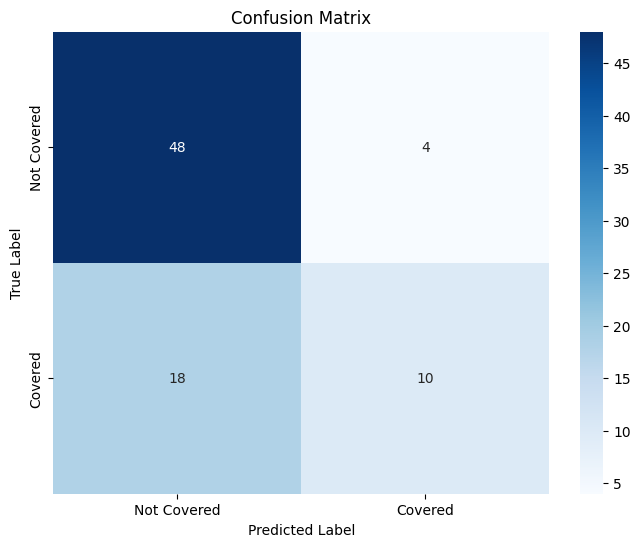

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert responses to boolean (True for 'covered', False for 'not covered')
y_pred = [response.strip() == "covered" for response in responses]
y_true = [claim.coverage for claim in test_dataset]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Covered", "Covered"],
    yticklabels=["Not Covered", "Covered"],
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### finetuning

In [23]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

We want to do Supervised Fine Tuning but we traditional Superverised Fine Tuning by default
learn from each token similarly to what is done during pre-training. For most use cases
this is not very useful (you are learning from the prompt and the output although it might bring
the model more into the topic as well) at the cost of extra resources:

Actually it can be interesting to try both approach, in reality if you use some API
you won't be able to try both approach and it is very likely that you will be using 
next token prediction with the loss computed and gradient average on the whole text instead
of just the result.

- https://github.com/huggingface/trl/issues/632 trl issue where this is explained and there is no definite conclusion on the matter
- https://huggingface.co/docs/trl/en/sft_trainer#train-on-completions-only we will train on completion only to compare with custom head also lower resource need
- 

In [24]:
print(prompts[0])

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
You are an Insurance Claim Expert.
You are given a claim description and a list of sources extracted from the insurance policy.
You need to determine if the claim is covered by the insurance policy.

Claim description:
I discovered someone had attempted to steal my car. The driver's side door lock was damaged, and the dashboard was dismantled, with the stereo missing. Is there any provision for covering transportation and accomodation?

Sources:
1. If your car, accessories or spare parts are lost, stolen or damaged, we will: - repair the damage; - replace what is lost or damaged and is too expensive to repair; or - pay you the cost of the loss or damage.
2. If your car is damaged, we will use one of our recommended repairers to repair it. If you choose not to use them, we may not pay more than our recommended repairer would have charged and we may choose to settle the clai

In [11]:
# we create a huggingface dataset which makes it easy to load into a pytorch dataset
# and to use with the trl library / SFTTrainer

# we just need a text column for SFT (next token prediction)
from datasets import Dataset

dataset = Dataset.from_list(
    [
        {
            # we just add covered / not covered to the prompt
            # depending on the claim coverage
            "text": claim_to_prompt(claim)
            + ("covered" if claim.coverage else "not covered")
        }
        for claim in train_dataset
    ]
)


NameError: name 'claim_to_prompt' is not defined

In [26]:
print(dataset[0]["text"])

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
You are an Insurance Claim Expert.
You are given a claim description and a list of sources extracted from the insurance policy.
You need to determine if the claim is covered by the insurance policy.

Claim description:
During a routine inspection, government officials arrived at the garage and declared that several car spare parts, including the catalytic converter and the exhaust system, were not compliant with new environmental regulations. Without prior notice, they ordered the immediate confiscation of these parts, citing the need to uphold public safety standards. Is there any recourse available for unexpected regulatory compliance issues?

Sources:
1. You are not covered for the following:
2. Confiscation or requisition or destruction by, or under the order of, any government or public or land authority.

Format:
Return only "covered" or "not covered"<|im_end|>
<|im_

In [27]:
# collator is responsible to format the text into batch of inputs for the model
# default collator would just TODO(Guillaume): add a way to show what's the difference
from trl import DataCollatorForCompletionOnlyLM

response_template = "<|im_start|>assistant\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [28]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,  # Can make training 5x faster for short sequences.
    args=TrainingArguments(
        per_device_train_batch_size=2,  # batch size = 2
        gradient_accumulation_steps=4,  # accumulate gradients 4 times -> equivalent to batch size 8
        warmup_steps=5,
        num_train_epochs=1,  # Set this for 1 full training run.
        # max_steps=60,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",  # Use this for WandB etc
    ),
    data_collator=collator,
)

torch.distributed process group is initialized, but parallel_mode != ParallelMode.DISTRIBUTED. In order to use Torch DDP, launch your script with `python -m torch.distributed.launch
torch.distributed process group is initialized, but parallel_mode != ParallelMode.DISTRIBUTED. In order to use Torch DDP, launch your script with `python -m torch.distributed.launch


Map (num_proc=2):   0%|          | 0/320 [00:00<?, ? examples/s]

In [29]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 320 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 40
 "-____-"     Number of trainable parameters = 119,734,272


Step,Training Loss
1,1.056700
2,0.785200
3,1.097500
4,0.877500
5,0.163000
6,0.360300
7,0.358900
8,0.312700
9,0.405900
10,0.358600


In [30]:
from vllm import SamplingParams

sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=2,  # set to 2 as not covered is 2 tokens
)
outputs = model.fast_generate(
    prompts,
    sampling_params=sampling_params,
    lora_request=None,
)

Processed prompts: 100%|██████████| 80/80 [00:08<00:00,  9.51it/s, est. speed input: 3449.95 toks/s, output: 19.02 toks/s]


In [31]:
responses = []
for response_output in outputs:
    responses.append(response_output.outputs[0].text)

responses

['not covered',
 'covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'not covere

In [32]:
print(
    f"Predicted {len([response for response in responses if response == 'covered'])} claims as covered"
)
print(
    f"Predicted {len([response for response in responses if response == 'not covered'])} claims as not covered"
)

Predicted 16 claims as covered
Predicted 64 claims as not covered


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred = [response.strip() == "covered" for response in responses]
y_true = [claim.coverage for claim in test_dataset]
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"F1 Score: {f1_score(y_true, y_pred)}")

Accuracy: 0.75
Precision: 0.75
Recall: 0.42857142857142855
F1 Score: 0.5454545454545454


We know observe better results, we can tweak more to get even better results.

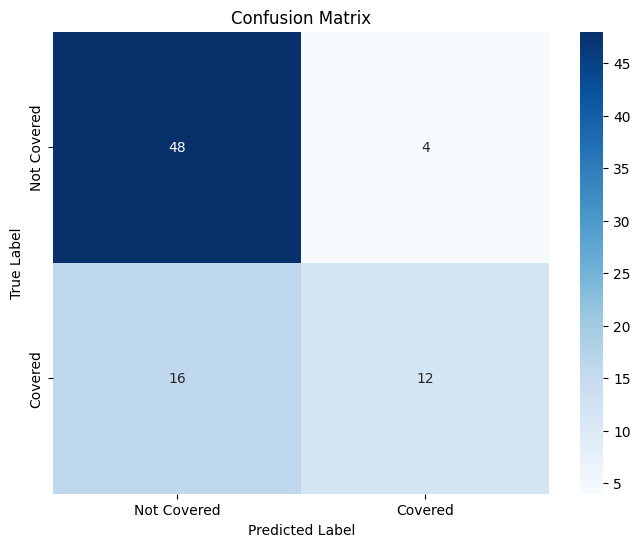

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert responses to boolean (True for 'covered', False for 'not covered')
y_pred = [response.strip() == "covered" for response in responses]
y_true = [claim.coverage for claim in test_dataset]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Covered", "Covered"],
    yticklabels=["Not Covered", "Covered"],
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Classification Approach

Instead of doing regular next token prediction as it is often the case we can also just modify the lm head and do classification instead. After all we don't need to predict over 151k values...

code found: https://github.com/timothelaborie/text_classification_scripts/blob/main/unsloth_classification.ipynb

In [9]:
from datasets import Dataset

In [1]:
from unsloth import FastLanguageModel

# from peft import LoftQConfig
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B-Instruct",
    max_seq_length=1024,
    load_in_4bit=True,  # False for LoRA 16bit
    fast_inference=False,  # Disable vLLM fast inference not compatible with training classification head
    max_lora_rank=64,
    gpu_memory_utilization=0.5,  # Reduce if out of memory
)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 02-10 17:50:30 __init__.py:190] Automatically detected platform cuda.
==((====))==  Unsloth 2025.2.5: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA GeForce RTX 2070. Max memory: 7.607 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [2]:
import torch

yes_token_id = tokenizer.encode("yes", add_special_tokens=False)[0]
no_token_id = tokenizer.encode("no", add_special_tokens=False)[0]

# keep only the yes and no tokens from lm_head
par = torch.nn.Parameter(
    torch.vstack(
        [model.lm_head.weight[no_token_id, :], model.lm_head.weight[yes_token_id, :]]
    )
)
print(par.shape)
print(model.lm_head.weight.shape)
model.lm_head.weight = par

torch.Size([2, 2048])
torch.Size([151936, 2048])


In [4]:
model.get_output_embeddings().modules_to_save.default.weight.dtype

torch.float32

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        # now we can fine tune the lm_head
        "lm_head",  # can easily be trained because it has only 2 tokens
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,  # Supports any, but = 0 is optimized
    bias="none",  # Supports any, but = "none" is optimized
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=True,  # We support rank stabilized LoRA
)
print(
    "trainable parameters:",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
)

Unsloth: Offloading output_embeddings to disk to save VRAM


/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/models/_utils.py:752: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  offloaded_W = torch.load(fil

Unsloth: Training lm_head in mixed precision to save VRAM
trainable parameters: 29937664


In [ ]:
# this custom collator is needed to change the sequence labels from yes_token_id and no_token_id to 1 and 0. It also trains only on the last token of the sequence.
from transformers import DataCollatorForLanguageModeling


class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
        self,
        *args,
        mlm: bool = False,
        ignore_index: int = -100,
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples) -> dict:
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            # Find the last non-padding token
            last_token_idx = (
                (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            )
            # Set all labels to ignore_index except for the last token
            batch["labels"][i, :last_token_idx] = self.ignore_index
            # The old labels for the Yes and No tokens need to be mapped to 1 and 0
            batch["labels"][i, last_token_idx] = (
                1 if batch["labels"][i, last_token_idx] == yes_token_id else 0
            )

        return batch


collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

### GRPO

With GRPO we can train our model to reason about the claim and the corresponding contract sources before giving us an answer.

Reinforcement learning enable the model to improve itself over the time leveraging a reward model. Traditionally people where using PPO and derivatives to perform RL(HF) to improve human preference on LLM. More recently deepseek introduced GRPO (Grouped Policy Optimization) which simplify PPO removing the need for a dedicated value model computing the advantage on each token prediction and relying on averaging the result from multiple output of the same policy model instead.This is what is behind the R1 model and it enables many model to become "reasoning" model.

[PPO vs GRPO](./images/PPO_VS_GRPO.png)

https://arxiv.org/pdf/2402.03300

GRPO is quite interesting as it allows us to define reward function giving a certain reward to a given response for from the "Policy Model" KL 

In [ ]:
# default reward functions from: https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb
import re
from datasets import load_dataset, Dataset

# Load and prep dataset
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""


def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()


# uncomment middle messages for 1-shot prompting
def get_claim_dataset_for_grpo() -> Dataset:
    data = Dataset.from_list(
        [
            {
                "question": claim_to_prompt(claim),
                "answer": {'covered' if claim.coverage else 'not covered'},
            }
            for claim in train_dataset
        ]
    )
    
    data = data.map(
        lambda x: {  # type: ignore
            "prompt": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": x["question"]},
            ],
            "answer": x["answer"],
        }
    )  # type: ignore
    return data  # type: ignore


dataset = get_claim_dataset_for_grpo()


# Reward functions
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]["content"] for completion in completions]
    q = prompts[0][-1]["content"]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print(
        "-" * 20,
        f"Question:\n{q}",
        f"\nAnswer:\n{answer[0]}",
        f"\nResponse:\n{responses[0]}",
        f"\nExtracted:\n{extracted_responses[0]}",
    )
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]


def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]["content"] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]


def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]


def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]


def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1]) * 0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1) * 0.001
    return count


def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]


In [ ]:
from trl import GRPOConfig, GRPOTrainer

training_args = GRPOConfig(
    use_vllm=True,  # use vLLM for fast inference!
    learning_rate=5e-6,
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    optim="adamw_8bit",
    logging_steps=1,
    bf16=is_bfloat16_supported(),
    fp16=not is_bfloat16_supported(),
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,  # Increase to 4 for smoother training
    num_generations=8,  # Decrease if out of memory
    max_prompt_length=256,
    max_completion_length=200,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps=250,
    save_steps=250,
    max_grad_norm=0.1,
    report_to="none",  # Can use Weights & Biases
    output_dir="outputs",
)